In [1]:
import csv
import json
import feather # pip install feather-format
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd
import ast
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
%matplotlib inline


In [2]:
## Some utility functions
def percentToInt(percentString):
    return int(percentString.rstrip("%"))
def trueFalseToBinary(tfstring):
    return 1 if tfstring=='t' else '0'
def stringListToList(stringList):
    return ast.literal_eval(stringList)
def stringListToCount(stringList):
    return len(ast.literal_eval(stringList))

In [3]:
reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"

reviews_data = pd.read_feather(reviews_data_path)
listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)

In [4]:
features_none_null = ["id","host_id","host_since","host_response_rate","host_acceptance_rate",
                        "host_response_time",
                        "host_is_superhost", "host_verifications",
                        # "host_has_profile_pic", "host_identity_verified",
                        # "neighbourhood_cleansed",
                        "latitude", "longitude",
                        "room_type", "accommodates", "amenities", "price", "minimum_nights", 
                        "availability_30",	"availability_60",	"availability_90","availability_365", 
                        "number_of_reviews", "review_scores_rating", 
                        "review_scores_accuracy",	"review_scores_cleanliness",	"review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value",
                        "instant_bookable", 
                        ]
reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"
reviews_data = pd.read_feather(reviews_data_path)
listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)

# reviews_data_path = "data/reviews.csv"
# listings_data_path = "data/listings.csv"
# calendar_data_path = "data/calendar.csv"
# reviews_data = pd.read_csv(reviews_data_path)
# listings_data = pd.read_csv(listings_data_path)
# calendar_data = pd.read_csv(calendar_data_path)

reviews_data = reviews_data.dropna()

df_none_null = listings_data.copy(deep = True)[features_none_null]

print("before droppign rows with null columns: ", df_none_null.shape)
for col in features_none_null:
    df_none_null = df_none_null[df_none_null[col].notna()]
print("after dropping rows with null columns: ", df_none_null.shape)


## most null columns - host_response_rate/accpetance rate, review_scores

reference_date = datetime.datetime(2021,7,12)
# adding custom: host_number_of_years
host_number_of_years = [(reference_date - datetime.datetime.strptime(i, '%Y-%m-%d')).days/365
                        for i in df_none_null['host_since']]
df_none_null["host_number_of_years"] = host_number_of_years
df_none_null['price'] = df_none_null['price'].map(lambda x:float(x[1:].replace(',', ''))).astype('int32')


# host reposnse rate; remove % sign, convert to integer
df_none_null['host_response_rate'] = df_none_null['host_response_rate'].map(percentToInt).astype('int32')
#  host_acceptance_rate:
df_none_null['host_acceptance_rate'] = df_none_null['host_acceptance_rate'].map(percentToInt).astype('int32')

# TODO host_response_time; arbitrary or one-hot
# df_none_null['host_response_time']= df_none_null['host_response_time'].map({
#     'within an hour':1, 'within a day':3, 'within a few hours':2,
#        'a few days or more':4
# })
host_response_time_dummies = pd.get_dummies(df_none_null['host_response_time'],prefix='host_response_time')
df_none_null = pd.concat([df_none_null,host_response_time_dummies], axis = 1)

# host_is_superhost: t/f to binary
df_none_null['host_is_superhost'] = df_none_null['host_is_superhost'].map(trueFalseToBinary).astype('int32')
# "host_verifications",
df_none_null['host_verifications'] = df_none_null['host_verifications'].map(stringListToCount).astype('int32')
# # "host_has_profile_pic" tf to binary
# df_none_null['host_has_profile_pic'] = df_none_null['host_has_profile_pic'].map(trueFalseToBinary).astype('int32')
# # "host_identity_verified",tf to binary
# df_none_null['host_identity_verified'] = df_none_null['host_identity_verified'].map(trueFalseToBinary).astype('int32')

# TODO "neighbourhood_cleansed" or leave out - lat long enough

# "latitude" pass
# "longitude", pass

# "room_type" ['Entire home/apt'4 'Private room'2 'Shared room'1 'Hotel room'3]
df_none_null['room_type'] = df_none_null['room_type'].map(
                            {'Entire home/apt':4,
                                'Private room':2,
                                 'Shared room':1,
                                  'Hotel room':3})

# "accommodates", pass
#  "amenities", 
df_none_null['amenities'] = df_none_null['amenities'].map(stringListToCount).astype('int32')
# "price", pass

# TODO "minimum_nights", to categorical? 3 categories [short medium long?]
# df_none_null['minimum_nights'] = df_none_null['minimum_nights']

# "availability_30",
df_none_null['availability_30'] = df_none_null['availability_30']/30.0
# "availability_60",
df_none_null['availability_60'] = df_none_null['availability_60']/60.0
# "availability_90",
df_none_null['availability_90'] = df_none_null['availability_90']/90.0
# "availability_365", 
df_none_null['availability_365'] = df_none_null['availability_365']/365.0

# "number_of_reviews" pass,

# all pass
# "review_scores_rating", 
# "review_scores_accuracy",
# "review_scores_cleanliness",
# 	"review_scores_checkin",	
# "review_scores_communication",
# "review_scores_location",
# 	"review_scores_value",

# "instant_bookable", 
df_none_null['instant_bookable'] = df_none_null['instant_bookable'].map(trueFalseToBinary).astype('int32')

df_none_null = df_none_null.drop(['host_response_time', 'host_since'], axis=1)


before droppign rows with null columns:  (3043, 28)
after dropping rows with null columns:  (1678, 28)


# Engineer more VARIABLEs here

In [5]:
df_none_null = df_none_null[(np.abs(stats.zscore(df_none_null['price'])) < 2)]

In [6]:
print(df_none_null['price'].describe())

count    1660.000000
mean      166.951205
std       120.817955
min         0.000000
25%        85.000000
50%       132.000000
75%       208.000000
max       750.000000
Name: price, dtype: float64


## Standarize features
### TODO: make certain binary features non-standardized

In [7]:
df = df_none_null.drop(['price', 'id','host_id'], axis=1)
df_normalized=(df - df.mean()) / df.std()
df_label = df_none_null['price']
X_train, X_test, y_train, y_test = train_test_split(df, df_label, test_size=0.1, random_state=101)



In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

87.70037298487816

In [9]:
train_preds

array([200, 149,  79, ..., 135, 520, 120], dtype=int32)

In [10]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

103.0019007895731

# Neural Network


In [11]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# https://www.tensorflow.org/tutorials/keras/regression
# sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [21]:
# X_train, X_test, y_train, y_test 
df = df_none_null.drop(['id','host_id'], axis=1)
df_normalized=(df - df.mean()) / df.std()
df_label = df_normalized['price']
df_normalized=df_normalized.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_normalized, df_label, test_size=0.1, random_state=101)

nnn = 200
model = keras.Sequential(
    [
        keras.Input(shape=X_train.shape),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(1),
    ]
)
#@title 4. dense model compile
batch_size = 300
epochs = 200
op = keras.optimizers.SGD(learning_rate = 0.1)
# op = keras.optimizers.Adam(learning_rate = 0.005)
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=op, metrics=tf.keras.metrics.MeanSquaredError())

model.fit(X_train, y_train.to_numpy(), batch_size=batch_size, epochs=epochs, validation_split=0.1)



Epoch 1/200
5/5 [==============================] - 0s 41ms/step - loss: 0.9816 - mean_squared_error: 0.9816 - val_loss: 1.0553 - val_mean_squared_error: 1.0553
Epoch 2/200
5/5 [==============================] - 0s 8ms/step - loss: 0.8082 - mean_squared_error: 0.8082 - val_loss: 0.8401 - val_mean_squared_error: 0.8401
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 1.3495 - mean_squared_error: 1.3495 - val_loss: 1.1012 - val_mean_squared_error: 1.1012
Epoch 4/200
5/5 [==============================] - 0s 9ms/step - loss: 0.8424 - mean_squared_error: 0.8424 - val_loss: 0.8057 - val_mean_squared_error: 0.8057
Epoch 5/200
5/5 [==============================] - 0s 9ms/step - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5930 - val_mean_squared_error: 0.5930
Epoch 6/200
5/5 [==============================] - 0s 9ms/step - loss: 0.4554 - mean_squared_error: 0.4554 - val_loss: 1.0962 - val_mean_squared_error: 1.0962
Epoch 7/200
5/5 [============================

In [22]:
model.evaluate(X_test, y_test, verbose=0)


[0.3046225607395172, 0.3046225607395172]

In [23]:
result = model.predict(X_test)
converted_rest = model.predict(X_test)*df_none_null['price'].std()+df_none_null['price'].mean()

difff= []
for i, j in enumerate(y_test*df_none_null['price'].std()+df_none_null['price'].mean()):
    difff.append(abs(converted_rest[i][0] - j))

/Users/jingyu/.pyenv/versions/3.9.6/envs/lab4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


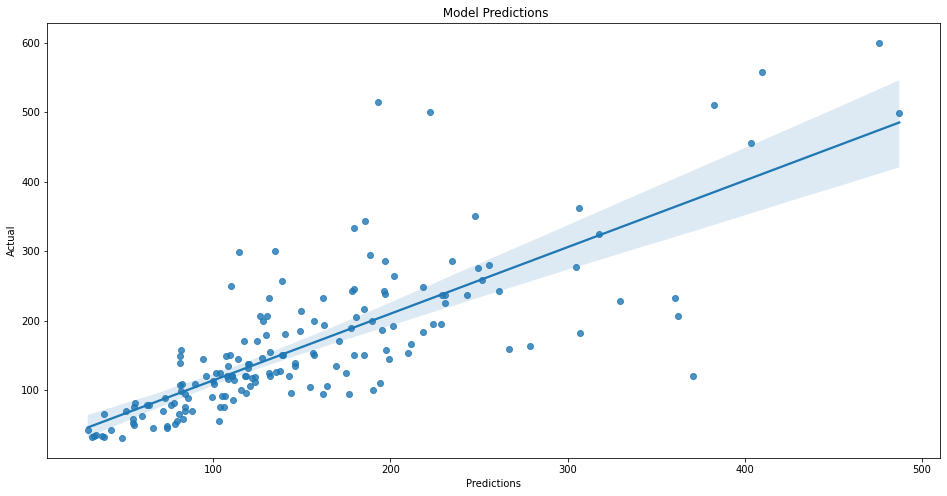

In [27]:
plt.figure(figsize=(16,8))
sns.regplot(converted_rest,y_test*df_none_null['price'].std()+df_none_null['price'].mean())
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title(" Model Predictions")
plt.grid(False)
plt.show()

In [24]:
np.array(difff).sum()

7081.823600769043

In [25]:
difff

[4.449241638183594,
 26.17572021484375,
 51.56103515625,
 3.3509902954101562,
 23.616622924804688,
 6.323760986328125,
 114.6324462890625,
 1.5634613037109375,
 7.224609375,
 12.094680786132812,
 35.60865783691406,
 69.99533081054688,
 30.873809814453125,
 10.317764282226562,
 39.704071044921875,
 8.351577758789062,
 16.962051391601562,
 25.371170043945312,
 28.949775695800795,
 83.8719482421875,
 250.5458984375,
 7.981842041015625,
 1.2884368896484375,
 28.501861572265625,
 18.717445373535156,
 22.639686584472656,
 24.673812866210938,
 10.612594604492188,
 76.56272888183594,
 51.07560729980469,
 21.202285766601577,
 27.52593994140625,
 27.869667053222656,
 26.513397216796875,
 3.5328826904296875,
 14.306243896484375,
 17.529769897460938,
 44.6766357421875,
 155.41726684570312,
 2.2790069580078125,
 12.330245971679688,
 1.8271636962890625,
 128.21197509765625,
 106.60942077636719,
 5.344635009765625,
 11.717269897460938,
 12.888183593750014,
 158.45449829101562,
 35.891693115234375,
 1

In [17]:
converted_rest = model.predict(X_test)*df_none_null['price'].std()+df_none_null['price'].mean()

In [28]:
converted_rest

array([[123.44924 ],
       [ 74.17572 ],
       [403.43896 ],
       [ 59.64901 ],
       [101.38338 ],
       [230.67624 ],
       [278.63245 ],
       [ 31.436539],
       [317.7754  ],
       [177.90532 ],
       [218.60866 ],
       [162.00467 ],
       [114.12619 ],
       [189.68224 ],
       [197.70407 ],
       [195.35158 ],
       [120.03795 ],
       [ 55.62883 ],
       [ 73.949776],
       [193.87195 ],
       [370.5459  ],
       [229.01816 ],
       [118.71156 ],
       [179.50186 ],
       [127.282555],
       [118.63969 ],
       [180.32619 ],
       [137.6126  ],
       [130.43727 ],
       [234.9244  ],
       [ 66.202286],
       [304.52594 ],
       [103.86967 ],
       [ 38.486603],
       [ 54.467117],
       [ 84.306244],
       [119.47023 ],
       [211.67664 ],
       [362.41727 ],
       [ 33.720993],
       [138.66975 ],
       [ 76.17284 ],
       [382.78802 ],
       [188.39058 ],
       [ 38.344635],
       [123.71727 ],
       [ 29.111816],
       [185.5

# predicting availability based on price and other


In [20]:
# "availability_30",	"availability_60",	"availability_90","availability_365", 
# X_train, X_test, y_train, y_test 
df = df_none_null.drop(['id','host_id',"availability_60",	"availability_90","availability_365"], axis=1)
df_normalized=(df - df.mean()) / df.std()
df_label = df_normalized["availability_30"]
df_normalized = df_normalized.drop(["availability_30"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_normalized, df_label, test_size=0.2, random_state=101)

nnn = 100
model = keras.Sequential(
    [
        keras.Input(shape=X_train.shape),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(1),
    ]
)
#@title 4. dense model compile
batch_size = 300
epochs = 200
op = keras.optimizers.SGD(learning_rate = 0.1)
# op = keras.optimizers.Adam(learning_rate = 0.005)
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=op, metrics=tf.keras.metrics.MeanSquaredError())

model.fit(X_train, y_train.to_numpy(), batch_size=batch_size, epochs=epochs, validation_split=0.2)



Epoch 1/200
4/4 [==============================] - 0s 52ms/step - loss: 1.0200 - mean_squared_error: 1.0200 - val_loss: 0.8349 - val_mean_squared_error: 0.8349
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 1.0073 - mean_squared_error: 1.0073 - val_loss: 0.8392 - val_mean_squared_error: 0.8392
Epoch 3/200
4/4 [==============================] - 0s 9ms/step - loss: 0.9917 - mean_squared_error: 0.9917 - val_loss: 0.8103 - val_mean_squared_error: 0.8103
Epoch 4/200
4/4 [==============================] - 0s 9ms/step - loss: 0.9711 - mean_squared_error: 0.9711 - val_loss: 0.7994 - val_mean_squared_error: 0.7994
Epoch 5/200
4/4 [==============================] - 0s 10ms/step - loss: 0.9703 - mean_squared_error: 0.9703 - val_loss: 0.8090 - val_mean_squared_error: 0.8090
Epoch 6/200
4/4 [==============================] - 0s 10ms/step - loss: 0.9379 - mean_squared_error: 0.9379 - val_loss: 0.8251 - val_mean_squared_error: 0.8251
Epoch 7/200
4/4 [=========================

In [ ]:
# predicting availability based on PRICE, HOST ratings, and AMENITIES and LOCATION ONLY
# engineer additional features